# Lab 1: Phân loại thư rác 

| MSSV     | Họ tên         | Email             |
|----------|----------------|-------------------|
| 21120022 | Cao Quảng Phát    | 21120022@student.hcmus.edu.vn |
| 21120074 | Tạ Công Hoàng      | 21120074@student.hcmus.edu.vn  |


In [2]:
# connect to drive & Prepare file to solve
# from google.colab import drive
# drive.mount('/content/drive')

lab_folder = './'  # Replace with your dataset's path
# lab_folder = '/content/drive/MyDrive/Đại học/Học kỳ 7/AiSec/Lab1'  # Replace with your dataset's path
train_csv_file = lab_folder + '/train.csv'
valid_csv_file = lab_folder + '/val.csv'

# Import Library

In [3]:
# import lib
import pandas as pd
import numpy as np
import copy


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# system
import os

# data preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from collections import Counter

# training model
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,classification_report, fbeta_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV

# Save Model
import pickle

# Ultilities
from tqdm.notebook import tqdm

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mac/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Read and Clean Data



## Read data

In [4]:
# Read data from file
train = pd.read_csv(train_csv_file, index_col='Message ID')
valid = pd.read_csv(valid_csv_file, index_col='Message ID')

In [5]:
train.head(5)

,Unnamed: 0,Subject,Message,Spam/Ham,split
Message ID,,,,,
0,0,christmas tree farm pictures,NaN,ham,0.038415
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,0.696509
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,0.587792
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,-0.055438
5,5,mcmullen gas for 11 / 99,"jackie ,\nsince the inlet to 3 river plant is ...",ham,-0.419658


In [6]:
valid.tail(5)

,Unnamed: 0,Subject,Message,Spam/Ham,split
Message ID,,,,,
33611,33611,re [ 2 ] : discussion about your health,ge\nri\nia\ns\nne\ncc\nli\nso\nb\nft\nta\ns\nb...,spam,0.544840
33621,33621,gain up to 3 + full inches in length,rated no . 1 penis enlargement pill on the mar...,spam,0.772489
33646,33646,your compliance is needed,name : mrs . suzana nuhan vaye\n% barr . james...,spam,0.210530
33650,33650,huge $ avings on all best - selling xp pro titles,opt - in email special offer unsubscribe me se...,spam,-1.270754
33692,33692,we have marked down the prices on all tablets ...,peruse our site and experience the advantages ...,spam,0.038307


## Clean data

In [7]:
dropColumns = ['Unnamed: 0', 'split']
resultCol = 'Result'
renameColumns = {'Spam/Ham': resultCol}

def data_cleaning(df):
    try:
      df.drop(columns=dropColumns, inplace=True)
    except:
      pass

    try:
      df.rename(columns=renameColumns, inplace=True)
    except:
      pass

    df['Subject'].fillna(' ', inplace=True)
    df['Message'].fillna(' ', inplace=True)
    df.drop_duplicates(keep='first', inplace=True)
    df['full_message'] = [' '.join([subject, message]) for subject, message in zip(df['Subject'], df['Message'])]

    print('shape: ', df.shape)
    # assert if some field is not zero
    assert df.isnull().sum().sum() == 0
    assert df.duplicated().sum() == 0
    return df

train = data_cleaning(train)
valid = data_cleaning(valid)

assert train.isnull().sum().sum() == 0
assert train.duplicated().sum() == 0
assert valid.isnull().sum().sum() == 0
assert valid.duplicated().sum() == 0

def hamData():
  return train[train[resultCol] == 'ham']
def spamData():
  return train[train[resultCol] == 'spam']

/var/folders/70/m4pwz78n73x_xqbtcmfmxt5c0000gn/T/ipykernel_66827/1209512657.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Subject'].fillna(' ', inplace=True)
/var/folders/70/m4pwz78n73x_xqbtcmfmxt5c0000gn/T/ipykernel_66827/1209512657.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

shape:  (25023, 4)


/var/folders/70/m4pwz78n73x_xqbtcmfmxt5c0000gn/T/ipykernel_66827/1209512657.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Subject'].fillna(' ', inplace=True)
/var/folders/70/m4pwz78n73x_xqbtcmfmxt5c0000gn/T/ipykernel_66827/1209512657.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

shape:  (3033, 4)


In [8]:
train.head(5)

,Subject,Message,Result,full_message
Message ID,,,,
0,christmas tree farm pictures,,ham,christmas tree farm pictures
1,"vastar resources , inc .","gary , production from the high island larger ...",ham,"vastar resources , inc . gary , production fro..."
2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,calpine daily gas nomination - calpine daily g...
3,re : issue,fyi - see note below - already done .\nstella\...,ham,re : issue fyi - see note below - already done...
5,mcmullen gas for 11 / 99,"jackie ,\nsince the inlet to 3 river plant is ...",ham,"mcmullen gas for 11 / 99 jackie ,\nsince the i..."


# EDA (Exploratory Data Analysis)

### Some insight about data
1. Number samples of each label => Pie Chart
2. Statistic: mean, median, mode, ...
3. Correlation between features

### Visualization
1. Pie Chart: To Compare %
2. Histograms
3. Pair **plots**

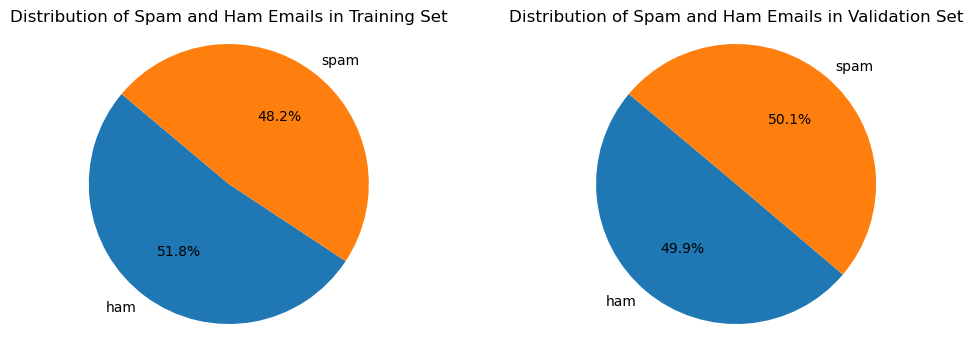

In [8]:
# Distribution of data
testLabelCount = train[resultCol].value_counts().sort_index()
validLabelCount = valid[resultCol].value_counts().sort_index()

## Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.pie(testLabelCount, labels=testLabelCount.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Spam and Ham Emails in Training Set')
plt.axis('equal')


plt.subplot(1, 2, 2)
plt.pie(validLabelCount, labels=validLabelCount.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Spam and Ham Emails in Validation Set')
plt.axis('equal')
plt.show()

In [9]:
# Statistic
train.describe()

## Length of mail
train.columns
train['Length'] = train['full_message'].apply(len)
train['num_words'] = train['full_message'].apply(word_tokenize).apply(len)
train['num_sentences'] = train['full_message'].apply(sent_tokenize).apply(len)
train.head(2)

# def compare_average_and_draw(col_name):
#   avg_spam = train[train[resultCol] == 'spam'][col_name].mean()
#   avg_ham = train[train[resultCol] == 'ham'][col_name].mean()
#   #plotting
#   print(f"Average {col_name} of Spam Emails:", avg_spam)
#   print(f"Average {col_name} of Ham Emails:", avg_ham)
#   plt.bar(['Spam', 'Ham'], [avg_spam, avg_ham], color=['Blue', 'Green'])
#   plt.title(f'Average {col_name} of Spam and Ham Emails')
#   plt.xlabel('Email Type')
#   plt.ylabel(f'Average {col_name}')
#   plt.show()
# compare_average_and_draw('Length')
# compare_average_and_draw('num_words')
# compare_average_and_draw('num_sentences')

# train.describe()

# hamData()[['Length', 'num_words', 'num_sentences']].describe()
# spamData()[['Length', 'num_words', 'num_sentences']].describe()

,Subject,Message,Result,full_message,Length,num_words,num_sentences
Message ID,,,,,,,
0,christmas tree farm pictures,,ham,christmas tree farm pictures,30,4,1
1,"vastar resources , inc .","gary , production from the high island larger ...",ham,"vastar resources , inc . gary , production fro...",4307,1577,24


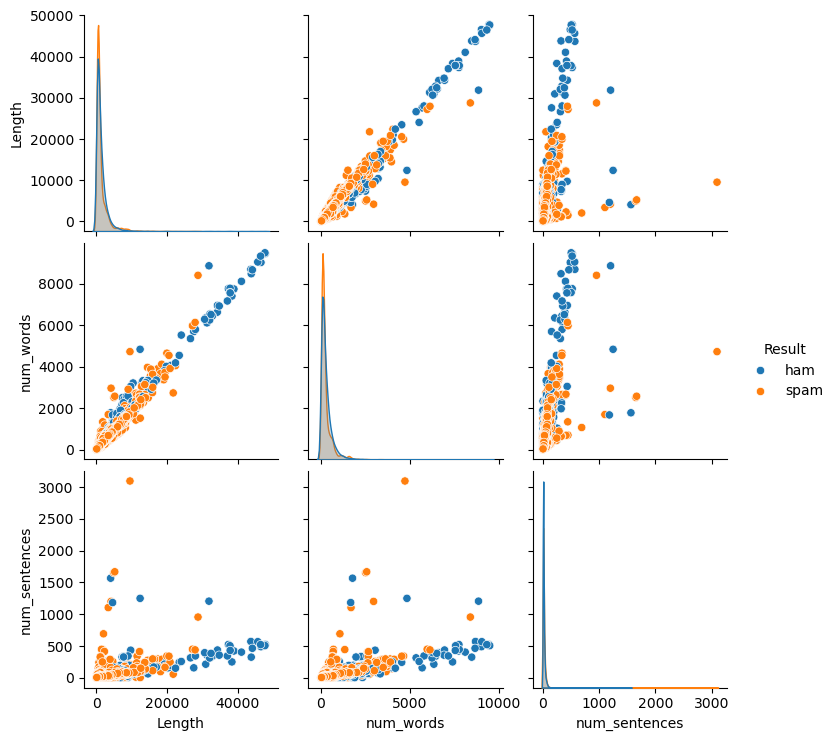

In [10]:
sns.pairplot(train,hue=resultCol)


<Axes: >

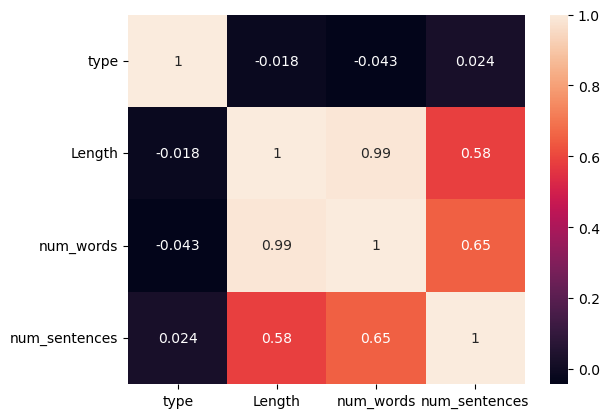

In [11]:
# Correlation between numerics features
train['type'] = train[resultCol].map({'ham': 0, 'spam': 1})
columns_to_select = ['type', 'Length', 'num_words', 'num_sentences'] # Select only numeric columns
numeric_data = train[columns_to_select]

## Heat map plot
sns.heatmap(numeric_data.corr(),annot=True)

In [12]:
# Drop Column after EDA
train.drop(columns=['Length', 'num_words', 'num_sentences', 'type'], inplace=True)
train.head(5)

,Subject,Message,Result,full_message
Message ID,,,,
0,christmas tree farm pictures,,ham,christmas tree farm pictures
1,"vastar resources , inc .","gary , production from the high island larger ...",ham,"vastar resources , inc . gary , production fro..."
2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,calpine daily gas nomination - calpine daily g...
3,re : issue,fyi - see note below - already done .\nstella\...,ham,re : issue fyi - see note below - already done...
5,mcmullen gas for 11 / 99,"jackie ,\nsince the inlet to 3 river plant is ...",ham,"mcmullen gas for 11 / 99 jackie ,\nsince the i..."


# Data Preprocessing

Flow:
1. Punctuation Removal
2. Lowering
3. Tokenize
4. StopWord Remove
5. Stemming
6. Lemmatization

In [9]:
# Follow this blog: https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/#:~:text=Text%20preprocessing%20is%20an%20essential,part%2Dof%2Dspeech%20tagging.
def lower_text(text):
    return text.lower()

def remove_punctuation(text):
    punctuationfree = "".join([i for i in text if i not in string.punctuation])
    return punctuationfree

def remove_stopwords(text):
    stopwords = nltk.corpus.stopwords.words('english')
    output= [i for i in text if i not in stopwords]
    return output

def stemming(text):
    porter_stemmer = PorterStemmer()
    stem_text = [porter_stemmer.stem(word) for word in text]
    return stem_text

def lemmatizer(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text

def preprocess_text_pipeline(text):
  """
  Preprocesses a given text string.
  """
   # 1. Lowercasing & Remove special word ???:
  text = lower_text(text)

  # 2. Removing punctuation:
  text = remove_punctuation(text)

  # 3. Tokenization:
  tokens = word_tokenize(text)

  # 4. Removing stop words:
  #Stop words present in the library
  # stopwords = nltk.corpus.stopwords.words('english')
  # stopwords[0:10]
  tokens = remove_stopwords(tokens)

  # 5. Stemming
  tokens = stemming(tokens)

  # 6. Lemmatization:
  tokens = lemmatizer(tokens)

  return ' '.join(tokens)



In [10]:
# Preprocess Text
def preprocess_text(df, filename = ""):
  """
  Preprocesses a given text string.
      - if text is preprocessed and save in file {filename} => only readfile
      - if text is not preprocessed and save in file {filename} => preprocess and save
  """
  # if filename and os.path.exists(filename):
  #     print("Loading preprocessed data from file...")
  #     temp_df = pd.read_csv(filename)
  #     df['transform_text'] = temp_df['transform_text']
  #     df.fillna('', inplace=True)
  # else:
  #     print("Preprocessing text...")
  #     df['transform_text'] = df['full_message'].astype('U').apply(preprocess_text_pipeline)
  #     if filename:
  #       print("Saving transform_text data to file...")
  #       df[['transform_text']].to_csv(filename, index=False)
  df['transform_text'] = df['full_message'].astype('U').apply(preprocess_text_pipeline)
  return df

train_after_preprocess_file = lab_folder + '/train_after_preprocess.csv'
valid_after_preprocess_file = lab_folder + '/valid_after_preprocess.csv'
train = preprocess_text(train, train_after_preprocess_file)
valid = preprocess_text(valid, valid_after_preprocess_file)

train.head()

,Subject,Message,Result,full_message,transform_text
Message ID,,,,,
0,christmas tree farm pictures,,ham,christmas tree farm pictures,christma tree farm pictur
1,"vastar resources , inc .","gary , production from the high island larger ...",ham,"vastar resources , inc . gary , production fro...",vastar resourc inc gari product high island la...
2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,calpine daily gas nomination - calpine daily g...,calpin daili ga nomin calpin daili ga nomin 1 doc
3,re : issue,fyi - see note below - already done .\nstella\...,ham,re : issue fyi - see note below - already done...,issu fyi see note alreadi done stella forward ...
5,mcmullen gas for 11 / 99,"jackie ,\nsince the inlet to 3 river plant is ...",ham,"mcmullen gas for 11 / 99 jackie ,\nsince the i...",mcmullen ga 11 99 jacki sinc inlet 3 river pla...


In [11]:
valid.tail(5)

,Subject,Message,Result,full_message,transform_text
Message ID,,,,,
33611,re [ 2 ] : discussion about your health,ge\nri\nia\ns\nne\ncc\nli\nso\nb\nft\nta\ns\nb...,spam,re [ 2 ] : discussion about your health ge\nri...,2 discus health ge ri ia ne cc li b ft ta boo ...
33621,gain up to 3 + full inches in length,rated no . 1 penis enlargement pill on the mar...,spam,gain up to 3 + full inches in length rated no ...,gain 3 full inch length rate 1 peni enlarg pil...
33646,your compliance is needed,name : mrs . suzana nuhan vaye\n% barr . james...,spam,your compliance is needed name : mrs . suzana ...,complianc need name mr suzana nuhan vay barr j...
33650,huge $ avings on all best - selling xp pro titles,opt - in email special offer unsubscribe me se...,spam,huge $ avings on all best - selling xp pro tit...,huge ave best sell xp pro titl opt email speci...
33692,we have marked down the prices on all tablets ...,peruse our site and experience the advantages ...,spam,we have marked down the prices on all tablets ...,mark price tablet chemist site peru site exper...


## Most Common Words in Spam Emails

In [12]:
def word_common_and_word_count(text, title = "Spam Emails", n = 10):
  if type(text) != str:
    text = ' '.join(text)

  words = text.split()
  word_counts = Counter(words)
  most_common_words = word_counts.most_common(n)
  print(f"Top {n} Most Common Words in {title}:")
  for word, count in most_common_words:
      print(f"{word}: {count} occurrences")

  # Generate Word Cloud
  # wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_words))
  wordcloud = WordCloud(max_words=100 , width=800 , height=400, background_color='white').generate(text)
  # Plot Word Cloud
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title(f'Word Cloud for Most Common Words in {title}')
  plt.axis('off')
  # Plot Bar Graph
  plt.subplot(1, 2, 2)
  words, counts = zip(*most_common_words)
  plt.bar(words, counts, color='orange')
  plt.title(f'Bar Graph for Most Common Words in {title}')
  plt.xlabel('Words')
  plt.ylabel('Frequency')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()


Top 10 Most Common Words in Spam Emails:
compani: 9798 occurrences
com: 8221 occurrences
1: 6886 occurrences
e: 6769 occurrences
u: 6504 occurrences
2: 6377 occurrences
http: 6310 occurrences
3: 6284 occurrences
inform: 6149 occurrences
email: 5930 occurrences


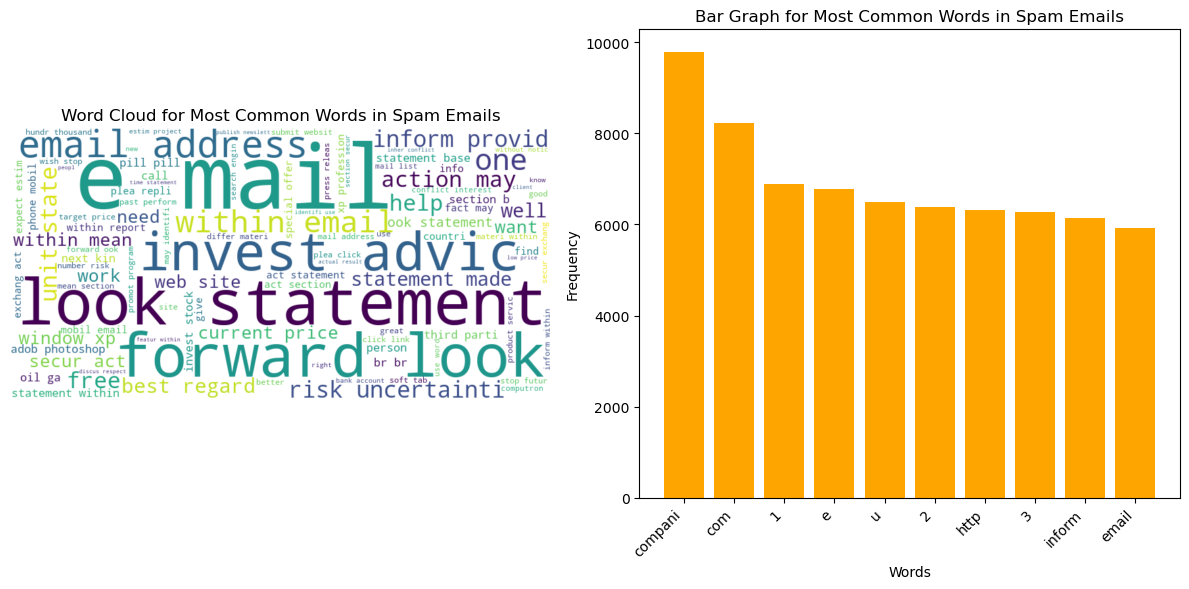

In [13]:
# Spam Email
spam_emails = spamData()['transform_text']
word_common_and_word_count(spam_emails, "Spam Emails")

Top 10 Most Common Words in Spam Emails:
enron: 33614 occurrences
ect: 28131 occurrences
hou: 13469 occurrences
plea: 10423 occurrences
2001: 10235 occurrences
2000: 9863 occurrences
subject: 9639 occurrences
com: 9473 occurrences
1: 8853 occurrences
would: 8058 occurrences


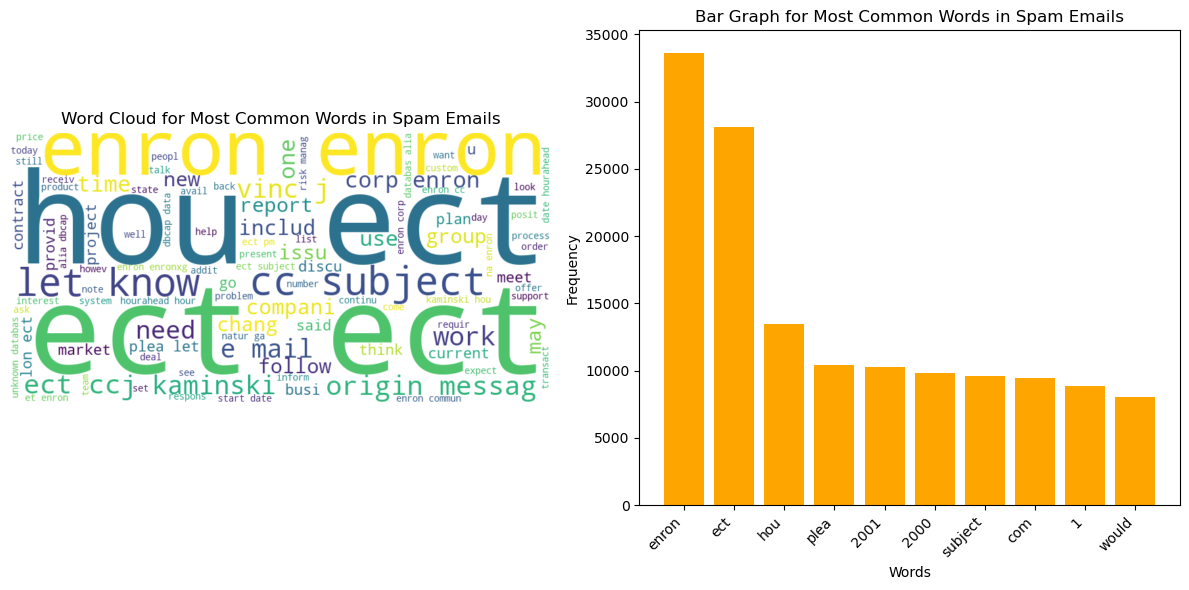

In [14]:
# Ham Email
ham_emails = hamData()['transform_text']
word_common_and_word_count(ham_emails, "Spam Emails")

# Prepare Data For Training
* Seperate train and valid data
* Label Encoding
* Vectorlization.
  * BoW
  * TFIDF

## Encode Data
- Which each data is not numerical, we need to encode it.
- Tool: `LabelEncoder()`

In [15]:
encoder = LabelEncoder()
train[resultCol] = encoder.fit_transform(train[resultCol])
# train[resultCol] = encoder.inverse_transform(train[resultCol]) # Use this method to revert label
train.sample(5)

,Subject,Message,Result,full_message,transform_text
Message ID,,,,,
27887,dashboard enhancements,in our continuing effort to expand the dashboa...,0,dashboard enhancements in our continuing effor...,dashboard enhanc continu effort expand dashboa...
12567,top marketer volumes still showing tremendous ...,fyi -\n- - - - - original message - - - - -\nf...,0,top marketer volumes still showing tremendous ...,top market volum still show tremend growth ngi...
14766,fw : office space in nyc as per your request,"fred - as per our conversation , can you give ...",0,fw : office space in nyc as per your request f...,fw offic space nyc per request fred per conver...
32962,digital cable filter,f / r / e / e cable tv\nthis is the newest and...,1,digital cable filter f / r / e / e cable tv\nt...,digit cabl filter f r e e cabl tv newest item ...
8512,one page background and position statement,"guys ,\nattached are the "" one - page "" backgr...",0,one page background and position statement guy...,one page background posit statement guy attach...


In [16]:
# count spam row
valid[resultCol] = encoder.transform(valid[resultCol])
valid.sample(5)

,Subject,Message,Result,full_message,transform_text
Message ID,,,,,
18171,""" quit your job and wo : rk on ebay , . sktion...",r .\ns\nlearn to make a\nfortune with ebay !\n...,1,""" quit your job and wo : rk on ebay , . sktion...",quit job wo rk ebay sktiondenoy r learn make f...
758,ena sales on hpl,just to update you on this project ' s status ...,0,ena sales on hpl just to update you on this pr...,ena sale hpl updat project statu base new repo...
15347,buy v茫lium and x . anax now,sa ; ve 7 _ 0 % ord . ering onl / ine to ` day...,1,buy v茫lium and x . anax now sa ; ve 7 _ 0 % or...,buy v茫lium x anax sa 7 0 ord ere onl ine day v...
24953,[ ilug ] earn 100 . 000 $ in one year working ...,hello\nyou may have seen this business before ...,1,[ ilug ] earn 100 . 000 $ in one year working ...,ilug earn 100 000 one year work home hello may...
16373,prescriptions for female sexual disfunction,inflame your passion . . . tonight !\nhttp : /...,1,prescriptions for female sexual disfunction in...,prescript femal sexual disfunct inflam passion...


In [17]:
encoder.classes_

array(['ham', 'spam'], dtype=object)

## Seperate train and valid Data

In [18]:
def X_train_no_preprocess():
  return train['full_message']

def X_valid_no_preprocess():
  return valid['full_message']

def X_train_preprocess():
  return train['transform_text']

def X_valid_preprocess():
  return valid['transform_text']

y_train = train[resultCol]
y_valid = valid[resultCol]

In [19]:
class ModelData:
  def __init__(self, X_train, y_train, X_valid, y_valid, data_name = ""):
    self.X_train = copy.deepcopy(X_train)
    self.y_train = copy.deepcopy(y_train)
    self.y_valid = copy.deepcopy(y_valid)
    self.X_valid = copy.deepcopy(X_valid)
    self.data_name = data_name
  def getName(self):
    return self.data_name

plain_model_data = ModelData(X_train_no_preprocess(), y_train, X_valid_no_preprocess(), y_valid, "plain_data")
preprocess_model_data = ModelData(X_train_preprocess(), y_train, X_valid_preprocess(), y_valid,  "preprocess_data")

In [20]:
X_train_preprocess() == preprocess_model_data.X_train

Message ID
0        True
1        True
2        True
3        True
5        True
         ... 
33709    True
33711    True
33712    True
33713    True
33714    True
Name: transform_text, Length: 25023, dtype: bool

## Vectorlization Text
  2 methods to use:
  1. BoW
  2. TFIDF

In [49]:
class Vectorlization:
  def __init__(self, methodCB, modelData = None, data = None, name=""):
    self.methodCB = methodCB
    self.vectorizer = None
    self.modelData  = None
    self.name = name

    if modelData is not None:
      self.fitModelData(copy.deepcopy(modelData))
    elif data is not None:
      self.fit(copy.deepcopy(data))

  def getName(self):
    return self.name

  def fit_transform(self, data):
    self.vectorizer = self.methodCB(data)

  def transform(self, data):
    return self.vectorizer.transform(data)

  def fitModelData(self, modelData):
    self.modelData =  modelData
    self.vectorizer = self.methodCB(self.modelData.X_train)
    self.modelData = self.transformModelData(self.modelData)
    return self.modelData

  def transformModelData(self, modelData):
    assert self.vectorizer is not None, "Vectorizer is not initialized. Let's call fitModelData"
    assert self.modelData is not None,  "ModelData is not None"
    modelData.X_train = self.vectorizer.transform(modelData.X_train)
    modelData.X_valid = self.vectorizer.transform(modelData.X_valid)
    return modelData

  def getModelData(self):
    return self.modelData

In [52]:
def vectorlization_with_Boolean(data):
  vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,2), binary=True)
  X = vectorizer.fit_transform(data)
  return vectorizer

class BooleanVectorlization(Vectorlization):
  def __init__(self, modelData = None):
    super().__init__(vectorlization_with_Boolean, modelData, name="Boolean_Vectorlization")

In [50]:
def vectorlization_with_BoW(data):
  vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,2))
  X = vectorizer.fit_transform(data)
  return vectorizer

class BoWVectorlization(Vectorlization):
  def __init__(self, modelData = None):
    super().__init__(vectorlization_with_BoW, modelData, name="BoW")

In [51]:
def vectorlization_with_TFIDF(data):
  vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2))
  X = vectorizer.fit_transform(data)
  return vectorizer

class TFIDFVectorlization(Vectorlization):
  def __init__(self, modelData = None):
    super().__init__(vectorlization_with_TFIDF, modelData, name="TFIDF")

In [25]:
bow = BoWVectorlization(plain_model_data)
print(bow.getName(), bow.getModelData().X_train.toarray())

BoW [[0 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [26]:
print(plain_model_data.X_train)
X_train_no_preprocess() == plain_model_data.X_train

Message ID
0                           christmas tree farm pictures  
1        vastar resources , inc . gary , production fro...
2        calpine daily gas nomination - calpine daily g...
3        re : issue fyi - see note below - already done...
5        mcmullen gas for 11 / 99 jackie ,\nsince the i...
                               ...                        
33709    cure premature ejaculation hello ,\ndid you ej...
33711    #ERROR! hello , welcome to gigapharm onlinne s...
33712    all prescript medicines are on special . to be...
33713    the next generation online pharmacy . are you ...
33714    bloow in 5 - 10 times the time learn how to la...
Name: full_message, Length: 25023, dtype: object


Message ID
0        True
1        True
2        True
3        True
5        True
         ... 
33709    True
33711    True
33712    True
33713    True
33714    True
Name: full_message, Length: 25023, dtype: bool

In [27]:
booleanVector = BooleanVectorlization(preprocess_model_data)
print(booleanVector.getModelData().X_train.toarray())

[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [28]:
print(preprocess_model_data.X_train)
X_train_preprocess() == preprocess_model_data.X_train

Message ID
0                                christma tree farm pictur
1        vastar resourc inc gari product high island la...
2        calpin daili ga nomin calpin daili ga nomin 1 doc
3        issu fyi see note alreadi done stella forward ...
5        mcmullen ga 11 99 jacki sinc inlet 3 river pla...
                               ...                        
33709    cure prematur ejacul hello ejacul within minut...
33711    error hello welcom gigapharm onlinn shop presc...
33712    prescript medicin special precis put buck back...
33713    next gener onlin pharmaci readi rock let man r...
33714    bloow 5 10 time time learn last 5 10 time long...
Name: transform_text, Length: 25023, dtype: object


Message ID
0        True
1        True
2        True
3        True
5        True
         ... 
33709    True
33711    True
33712    True
33713    True
33714    True
Name: transform_text, Length: 25023, dtype: bool

## Evaluation

In [29]:
class Evaluation:
  """
  Base class for evaluation metrics.
  Follow this link: https://scikit-learn.org/1.5/modules/model_evaluation.html#scoring-parameter
  """
  def __init__(self, evaluationName, evaluationCB, evaluationCode):
    self.name = evaluationName
    self.evaluate = evaluationCB
    self.evaluationCode = evaluationCode

  def evaluate(self, y_true, y_predict):
    return self.evaluate(y_true=y_true.copy(), y_pred=y_predict.copy())

In [30]:
class Accuracy(Evaluation):
  def __init__(self):
    super().__init__("Accuracy", accuracy_score, "accuracy")

class Precision(Evaluation):
  def __init__(self):
    super().__init__("Precision", precision_score, "precision")

class Recall(Evaluation):
  def __init__(self):
    super().__init__("Recall", recall_score, "recall")

class F1Score(Evaluation):
  def __init__(self):
    super().__init__("F1_Score", f1_score, "f1")

class F05Score(Evaluation):
  def __init__(self):
    super().__init__("F05_Score", lambda y_true, y_pred: fbeta_score(y_true=y_true, y_pred=y_pred, beta=0.5), "f0.5")

class ConfusionMatrix(Evaluation):
  def __init__(self):
    super().__init__("ConfusionMatrix", confusion_matrix, "confusion_matrix")

In [31]:
class EvaluationListManager:
  def __init__(self, evaluationList):
    self.evaluationList = evaluationList
  def __len__(self):
        return self.evaluationList.__len__()

  def evaluate(self, y_true, y_predict, is_report = False):
    result = {}
    for evaluation in self.evaluationList:
      try:
        result[evaluation.name] = evaluation.evaluate(y_true=y_true, y_pred=y_predict)
      except Exception as e:
        print(f"Error in {evaluation.name}: {e}")

    if is_report:
      print("evaluate report: \n",classification_report(y_true=y_true, y_pred=y_predict, target_names=encoder.classes_))
      for key, value in result.items():
        print(f"{key}: {value}")
      sns.heatmap(confusion_matrix(y_true=y_true, y_pred=y_predict), annot=True, cmap='Blues', fmt='.0f')

    return result

  def getEvaluationNames(self):
    return [evaluation.name for evaluation in self.evaluationList]
  def getEvaluations(self):
    return self.evaluationList

# evaluationListManger = EvaluationListManager([Accuracy(), Precision(), Recall(), F1Score(), F05Score(), ConfusionMatrix()])
evaluationListManger = EvaluationListManager([Accuracy(), Precision(), Recall(), F1Score(), F05Score()])

# Training model
* Baseline: Logistic Regression - Compare with 2 types of vectorization.

### Models Config

In [32]:
class ModelConfig:
  def __init__(self, baseModel, hparamsSpace, modelName):
    self.baseModel = baseModel
    self.hparamsSpace = hparamsSpace
    self.modelName = modelName
  def getModelName(self):
    return self.modelName

In [33]:
class LogisticRegressionConfig(ModelConfig):
  def __init__(self):
    self.hparamsSpace = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 100],
        'penalty': ['l2'],
        'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    }
    super().__init__(LogisticRegression(), self.hparamsSpace, "LogisticRegression")

In [34]:
class SVMConfig(ModelConfig):
  def __init__(self):
    self.hparamsSpace = {
        "C": [.01, .1, 1, 5, 10, 100],
        "gamma": [.01, .1, 1, 5, 10, 100],
        "kernel": ["rbf"],
        "random_state": [1]
    }
    super().__init__(SVC(), self.hparamsSpace, "SVM")

In [35]:
class RandomForestConfig(ModelConfig):
  def __init__(self):
    self.hparamsSpace = {
        'bootstrap': [True, False],
        'max_depth': [10, 20, 50, 100, None],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [50, 100]
    }
    super().__init__(RandomForestClassifier(), self.hparamsSpace, "RandomForest")


In [36]:
class NaiveBayesConfig(ModelConfig):
  def __init__(self):
    self.hparamsSpace = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}
    super().__init__(MultinomialNB(), self.hparamsSpace, "NaiveBayes")

### Model Class

In [56]:
class Model:
  def __init__(self, modelConfig, modelData, vectorlization, evaluationListManger):
    self.modelConfig = modelConfig
    self.modelData = copy.deepcopy(modelData)
    self.modelDataVectorlized = None   # ModelData after vectorlization
    self.vectorlization = vectorlization
    self.evaluationListManger = evaluationListManger
    self.model = None
    print(f'init model {self.getModelName()}')
    self.fitVectorlization()
    self.vectorlizedModelData()
    

  def fitVectorlization(self):
    self.vectorlization.fit_transform(self.modelData.X_train)
    return self

  def vectorlizedModelData(self):
    self.modelDataVectorlized = ModelData(
        self.vectorlization.transform(self.modelData.X_train),
        self.modelData.y_train,
        self.vectorlization.transform(self.modelData.X_valid),
        self.modelData.y_valid,
        self.modelData.getName()
    )
    return self
  def getModelName(self):
    return "_".join([self.modelConfig.getModelName(), self.modelData.getName(), self.vectorlization.getName()])

  def getModelSaveFile(self, suffixName = ""):
    return lab_folder + "/" + self.getModelName() + suffixName +  '.pkl'

  def loadModel(self):
    saveFile = self.getModelSaveFile()
    if os.path.exists(saveFile):
      with open(saveFile, 'rb') as file:
        self.model = pickle.load(file)
      print(f"Model {self.getModelName()} load from {saveFile}")
      return True
    else:
      print(f"Cannot find Model {self.getModelName()} to load")
      return False

  def saveModel(self, suffixName = ""):
    if self.model is None:
      print(f"Model {self.getModelName()} is not trained")
      return
    saveFile = self.getModelSaveFile(suffixName)
    if os.path.exists(saveFile):
      os.remove(saveFile)
    with open(saveFile, 'wb') as file:
      pickle.dump(self.model, file)
    print(f"Model {self.getModelName()} saved to {saveFile}")

  def train(self):
    """
    Train with default hyperparameters
    """
    if(self.model is not None):
      print(f"Model {self.getModelName()} is already trained")
      return self
    self.model = self.modelConfig.baseModel
    self.model.fit(self.modelDataVectorlized, self.modelDataVectorlized.y_train)
    return self

  def optimize_with_search(self, scoring = 'accuracy'):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=self.modelConfig.baseModel, param_grid=self.modelConfig.hparamsSpace, n_jobs=-1, cv=5, scoring=scoring, verbose=2)
    # RCV = RandomizedSearchCV(
    #     estimator=self.modelConfig.baseModel,
    #     param_distributions=self.modelConfig.hparamsSpace,
    #     n_iter=50,
    #     scoring='accuracy',
    #     n_jobs=-1,
    #     # cv=3,
    #     cv=5,
    #     random_state=1,
    #     verbose=2
    # )

    # Wrap the fit method with tqdm to display progress
    # with tqdm(total=RCV.n_iter, desc=f"Randomized Search of {self.getModelName()}") as pbar:
    #     def update(pipeline, _):
    #         pbar.update()

    #     result = RCV.fit(self.modelData.X_train, self.modelData.y_train)
    #     RCV.register_callback('on_step', update)

    result = grid_search.fit(self.modelDataVectorlized.X_train, self.modelDataVectorlized.y_train)
    self.model = result.best_estimator_
    self.saveModel(f"_{scoring}_best")
    print(f"Best: {result.best_score_} using {result.best_params_}")
    return result

  def predict(self, X): 
    if self.model is None:
      print("Model is not trained")
      return None
    X = self.vectorlization.transform(X)
    return self.model.predict(X)

  def y_predict(self):
    return self.predict(self.modelData.X_valid)

  def y_true(self):
    return self.modelData.y_valid

  def evaluate_valid(self, is_report = False):
    return self.evaluate(self.modelData.X_valid, self.modelData.y_valid, is_report)
  def evaluate_train(self, is_report = False):
    return self.evaluate(self.modelData.X_train, self.modelData.y_train, is_report)
  
  def evaluate(self, X = None, y = None, is_report = False):
    if self.model is None:
      print("Model is not trained")
      return None
    if(is_report):
      print(f"Model {self.getModelName()}")

    y_predict = self.y_predict()
    y_true = self.y_true()

    if X is not None and y is not None:
      y_predict = self.predict(X)
      y_true = y
      
    return self.evaluationListManger.evaluate(y_true=y_true, y_predict=y_predict, is_report=is_report)


In [38]:
def validation_model(y_true, y_predict):
  accuracy_svc = accuracy_score(y_true=y_true, y_pred=y_predict)
  print(f"Accuracy: {accuracy_svc:.6f}")
  print("confusion Matrix :\n",confusion_matrix(y_true=y_true, y_pred=y_predict))
  print("Precision Score: ",precision_score(y_true=y_true, y_pred=y_predict))
  print("Recall Score: ",recall_score(y_true=y_true, y_pred=y_predict))
  print("F1 Score: ",f1_score(y_true=y_true, y_pred=y_predict))
  print("F0.5 Score:", fbeta_score(y_true=y_true, y_pred=y_predict, beta=0.5))
  print("F2 Score:", fbeta_score(y_true=y_true, y_pred=y_predict, beta=2))
  print(classification_report(y_true=y_true, y_pred=y_predict, target_names=encoder.classes_))

### Model Evaluation Report

In [39]:
# Use this code to draw cm: https://www.kaggle.com/code/yasserh/email-spam-detection-comparing-best-ml-models?scriptVersionId=83854205&cellId=77
import math
class Evaluation_Models_Results:
  def __init__(self, models, evaluationListManger:EvaluationListManager, name):
    self.models = models
    self.evaluationListManger = evaluationListManger
    self.result = None
    self.initResult()
    self.name = name

  def getName(self):
    return self.name
  def getReportFileName(self):
    return lab_folder + "/" + self.name + "_report.csv"
  def saveReport(self, result):
    result.to_csv(self.getReportFileName(), index=False)
    return result

  def nModels(self):
    return len(self.models)

  def evaluationList(self):
    return self.evaluationListManger.getEvaluations()

  def nEvaluation(self):
    return len(self.evaluationList())


  def getEvaluationNames(self):
    return [evaluation.name for evaluation in self.evaluationList()]

  def initResult(self):
    self.result = pd.DataFrame(np.zeros((self.nModels(), self.nEvaluation())), columns=self.getEvaluationNames())
    return self.result

  def fill_result_item(self, model_idx, evaluation_name, value):
    self.result.loc[model_idx, evaluation_name] = value

  def fill_result(self, model_idx, modelResult: dict):
    for evaluation_name in modelResult:
        value = modelResult[evaluation_name]
        self.fill_result_item(model_idx, evaluation_name, value)

  def collect_result(self):
    idx = -1
    for model in self.models:
      idx += 1
      modelResult = model.train().evaluate(is_report=True)
      model.saveModel()
      self.fill_result(idx, modelResult)
    return self.result

  def draw_confusion_matrix(self):
    print('\033[1mConfusion Matrix Comparison'.center(100))

    num_models = self.nModels()
    cols = 4  # Number of columns in the plot grid
    rows = math.ceil(num_models / cols)  # Calculate the number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i in range(num_models):
        pred = self.models[i].y_predict()
        Test_Y = self.models[i].y_true()
        cm = confusion_matrix(Test_Y, pred)

        sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f', ax=axes[i])
        axes[i].set_title(self.models[i].getModelName())
        axes[i].set_xlabel('Predicted Labels')
        axes[i].set_ylabel('True Labels')

    # Hide any unused subplots
    for j in range(num_models, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

  def draw_table_compare_all_scores(self):
    print('\033[1mML Algorithms Comparison'.center(100))
    plt.figure(figsize=[12,8])
    sns.heatmap(self.result, annot=True, vmin=90, vmax=100, cmap='Blues', fmt='.1f')
    plt.show()

  def generate_report(self):
    result = self.collect_result()
    self.draw_confusion_matrix()
    # self.draw_table_compare_all_scores()
    result.insert(0, 'Model', [model.getModelName() for model in self.models])
    print(result)
    self.saveReport(result)
    return self.result



### List all Model

Data: plain
Vectorlization: Boolean_Vectorlization
init model LogisticRegression_plain_data_Boolean_Vectorlization
init model SVM_plain_data_Boolean_Vectorlization
init model RandomForest_plain_data_Boolean_Vectorlization
init model NaiveBayes_plain_data_Boolean_Vectorlization


Training LogisticRegression_plain_data_Boolean_Vectorlization:   0%|          | 0/100 [00:00<?, ?it/s]

Model LogisticRegression_plain_data_Boolean_Vectorlization
evaluate report: 
               precision    recall  f1-score   support

         ham       1.00      0.98      0.99      1514
        spam       0.98      1.00      0.99      1519

    accuracy                           0.99      3033
   macro avg       0.99      0.99      0.99      3033
weighted avg       0.99      0.99      0.99      3033

Accuracy: 0.9894493900428618
Precision: 0.9837345478204295
Recall: 0.9953917050691244
F1_Score: 0.9895287958115183
F05_Score: 0.9860440850397809
Model LogisticRegression_plain_data_Boolean_Vectorlization saved to .//LogisticRegression_plain_data_Boolean_Vectorlization.pkl


Training SVM_plain_data_Boolean_Vectorlization:   0%|          | 0/100 [00:00<?, ?it/s]

Model SVM_plain_data_Boolean_Vectorlization
evaluate report: 
               precision    recall  f1-score   support

         ham       1.00      0.96      0.98      1514
        spam       0.96      1.00      0.98      1519

    accuracy                           0.98      3033
   macro avg       0.98      0.98      0.98      3033
weighted avg       0.98      0.98      0.98      3033

Accuracy: 0.9769205407187603
Precision: 0.9582542694497154
Recall: 0.9973666886109283
F1_Score: 0.9774193548387097
F05_Score: 0.9658294020145353
Model SVM_plain_data_Boolean_Vectorlization saved to .//SVM_plain_data_Boolean_Vectorlization.pkl


Training RandomForest_plain_data_Boolean_Vectorlization:   0%|          | 0/100 [00:00<?, ?it/s]

Model RandomForest_plain_data_Boolean_Vectorlization
evaluate report: 
               precision    recall  f1-score   support

         ham       0.99      0.98      0.98      1514
        spam       0.98      0.99      0.98      1519

    accuracy                           0.98      3033
   macro avg       0.98      0.98      0.98      3033
weighted avg       0.98      0.98      0.98      3033

Accuracy: 0.9845037916254533
Precision: 0.9797913950456323
Recall: 0.989466754443713
F1_Score: 0.9846053062561415
F05_Score: 0.9817112998040496
Model RandomForest_plain_data_Boolean_Vectorlization saved to .//RandomForest_plain_data_Boolean_Vectorlization.pkl


Training NaiveBayes_plain_data_Boolean_Vectorlization:   0%|          | 0/100 [00:00<?, ?it/s]

Model NaiveBayes_plain_data_Boolean_Vectorlization
evaluate report: 
               precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1514
        spam       0.99      0.99      0.99      1519

    accuracy                           0.99      3033
   macro avg       0.99      0.99      0.99      3033
weighted avg       0.99      0.99      0.99      3033

Accuracy: 0.9904385097263435
Precision: 0.9946879150066401
Recall: 0.9861751152073732
F1_Score: 0.9904132231404958
F05_Score: 0.9929736179239029
Model NaiveBayes_plain_data_Boolean_Vectorlization saved to .//NaiveBayes_plain_data_Boolean_Vectorlization.pkl
                                  Confusion Matrix Comparison                                   


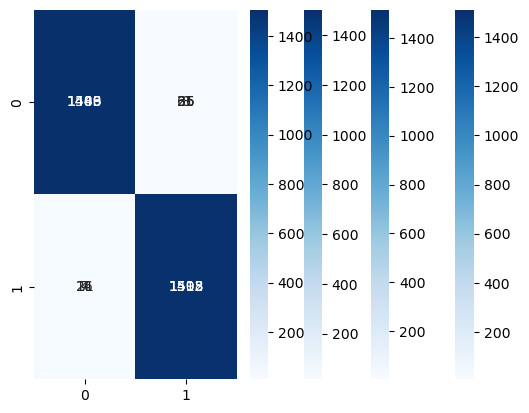

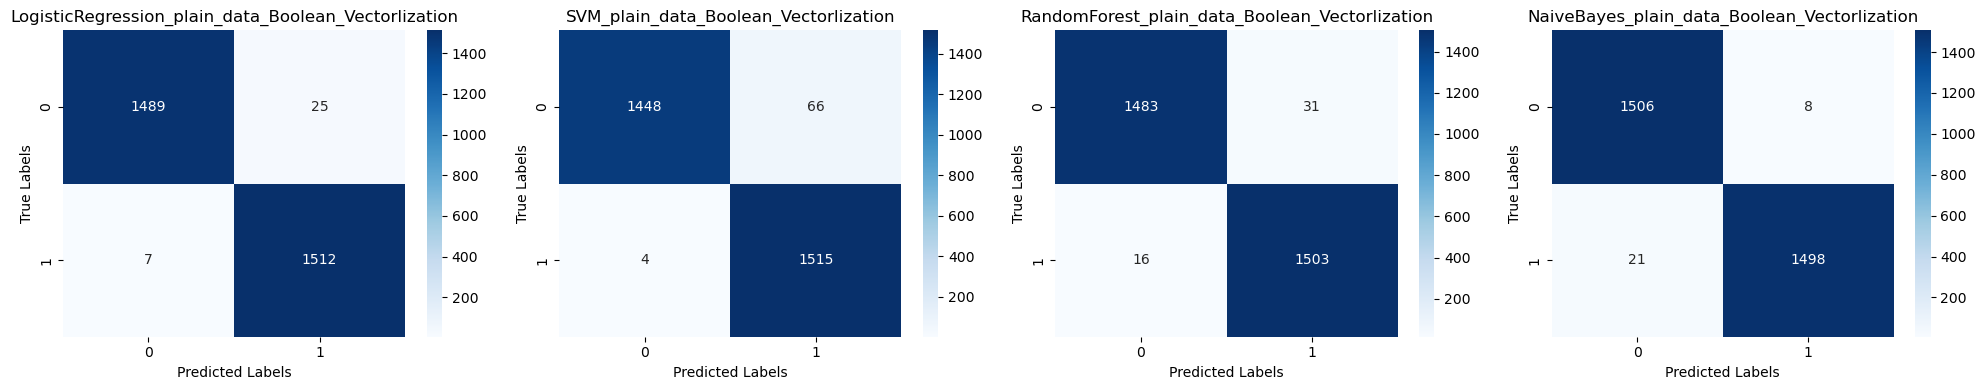

                                               Model  Accuracy  Precision  \
0  LogisticRegression_plain_data_Boolean_Vectorli...  0.989449   0.983735   
1              SVM_plain_data_Boolean_Vectorlization  0.976921   0.958254   
2     RandomForest_plain_data_Boolean_Vectorlization  0.984504   0.979791   
3       NaiveBayes_plain_data_Boolean_Vectorlization  0.990439   0.994688   

     Recall  F1_Score  F05_Score  
0  0.995392  0.989529   0.986044  
1  0.997367  0.977419   0.965829  
2  0.989467  0.984605   0.981711  
3  0.986175  0.990413   0.992974  
Vectorlization: BoW
init model LogisticRegression_plain_data_BoW
init model SVM_plain_data_BoW
init model RandomForest_plain_data_BoW
init model NaiveBayes_plain_data_BoW


Training LogisticRegression_plain_data_BoW:   0%|          | 0/100 [00:00<?, ?it/s]

Model LogisticRegression_plain_data_BoW
evaluate report: 
               precision    recall  f1-score   support

         ham       1.00      0.98      0.99      1514
        spam       0.98      1.00      0.99      1519

    accuracy                           0.99      3033
   macro avg       0.99      0.99      0.99      3033
weighted avg       0.99      0.99      0.99      3033

Accuracy: 0.9897790966040224
Precision: 0.984375
Recall: 0.9953917050691244
F1_Score: 0.9898527004909984
F05_Score: 0.9865587889860368
Model LogisticRegression_plain_data_BoW saved to .//LogisticRegression_plain_data_BoW.pkl


Training SVM_plain_data_BoW:   0%|          | 0/100 [00:00<?, ?it/s]

Model SVM_plain_data_BoW
evaluate report: 
               precision    recall  f1-score   support

         ham       0.99      0.93      0.96      1514
        spam       0.94      0.99      0.96      1519

    accuracy                           0.96      3033
   macro avg       0.96      0.96      0.96      3033
weighted avg       0.96      0.96      0.96      3033

Accuracy: 0.9601055060995713
Precision: 0.9363295880149812
Recall: 0.9874917709019092
F1_Score: 0.9612303748798462
F05_Score: 0.9461334678945377
Model SVM_plain_data_BoW saved to .//SVM_plain_data_BoW.pkl


Training RandomForest_plain_data_BoW:   0%|          | 0/100 [00:00<?, ?it/s]

Model RandomForest_plain_data_BoW
evaluate report: 
               precision    recall  f1-score   support

         ham       0.99      0.98      0.98      1514
        spam       0.98      0.99      0.98      1519

    accuracy                           0.98      3033
   macro avg       0.98      0.98      0.98      3033
weighted avg       0.98      0.98      0.98      3033

Accuracy: 0.9848334981866139
Precision: 0.9798045602605863
Recall: 0.990125082290981
F1_Score: 0.9849377865094957
F05_Score: 0.9818514166340253
Model RandomForest_plain_data_BoW saved to .//RandomForest_plain_data_BoW.pkl


Training NaiveBayes_plain_data_BoW:   0%|          | 0/100 [00:00<?, ?it/s]

Model NaiveBayes_plain_data_BoW
evaluate report: 
               precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1514
        spam       0.99      0.99      0.99      1519

    accuracy                           0.99      3033
   macro avg       0.99      0.99      0.99      3033
weighted avg       0.99      0.99      0.99      3033

Accuracy: 0.9904385097263435
Precision: 0.9933774834437086
Recall: 0.9874917709019092
F1_Score: 0.9904258831297458
F05_Score: 0.9921947347532742
Model NaiveBayes_plain_data_BoW saved to .//NaiveBayes_plain_data_BoW.pkl
                                  Confusion Matrix Comparison                                   


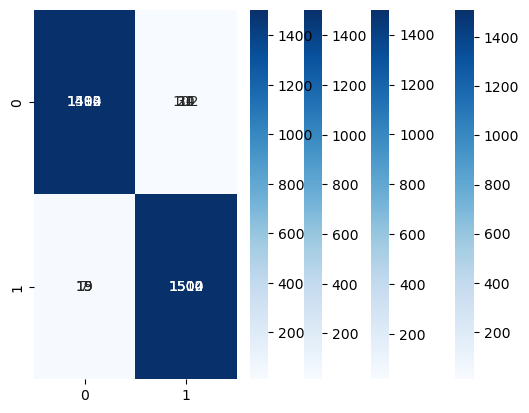

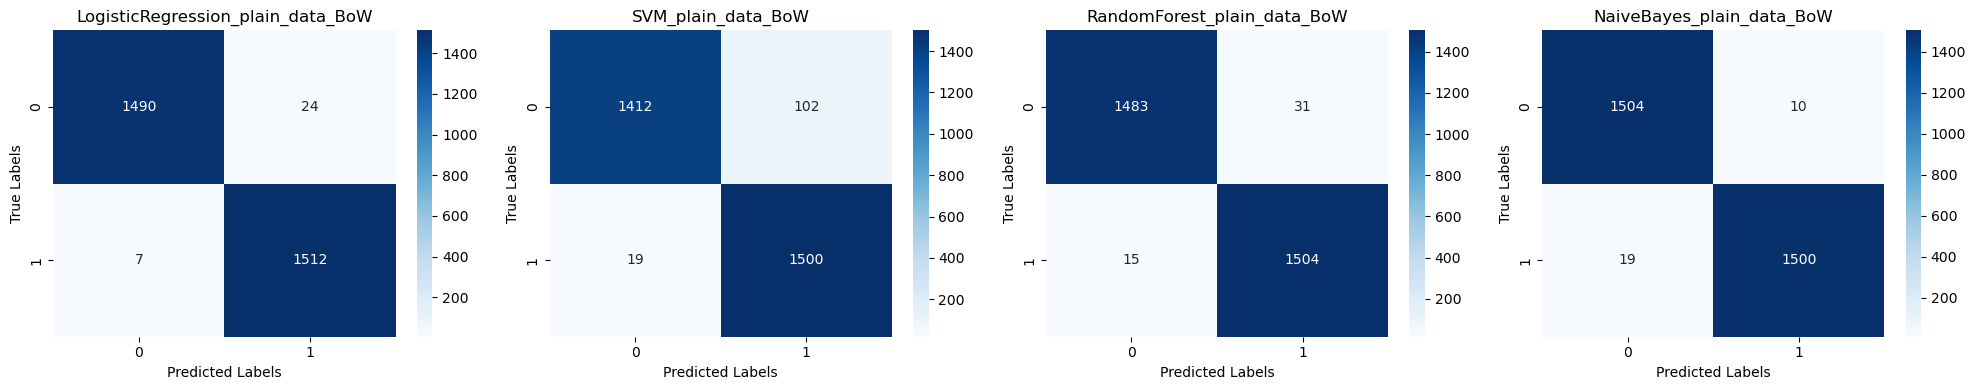

                               Model  Accuracy  Precision    Recall  F1_Score  \
0  LogisticRegression_plain_data_BoW  0.989779   0.984375  0.995392  0.989853   
1                 SVM_plain_data_BoW  0.960106   0.936330  0.987492  0.961230   
2        RandomForest_plain_data_BoW  0.984833   0.979805  0.990125  0.984938   
3          NaiveBayes_plain_data_BoW  0.990439   0.993377  0.987492  0.990426   

   F05_Score  
0   0.986559  
1   0.946133  
2   0.981851  
3   0.992195  
Vectorlization: TFIDF
init model LogisticRegression_plain_data_TFIDF
init model SVM_plain_data_TFIDF
init model RandomForest_plain_data_TFIDF
init model NaiveBayes_plain_data_TFIDF


Training LogisticRegression_plain_data_TFIDF:   0%|          | 0/100 [00:00<?, ?it/s]

Model LogisticRegression_plain_data_TFIDF
evaluate report: 
               precision    recall  f1-score   support

         ham       0.99      0.98      0.99      1514
        spam       0.98      0.99      0.99      1519

    accuracy                           0.99      3033
   macro avg       0.99      0.99      0.99      3033
weighted avg       0.99      0.99      0.99      3033

Accuracy: 0.9851632047477745
Precision: 0.9767141009055628
Recall: 0.9940750493745886
F1_Score: 0.9853181076672104
F05_Score: 0.9801376087238738
Model LogisticRegression_plain_data_TFIDF saved to .//LogisticRegression_plain_data_TFIDF.pkl


Training SVM_plain_data_TFIDF:   0%|          | 0/100 [00:00<?, ?it/s]

Model SVM_plain_data_TFIDF
evaluate report: 
               precision    recall  f1-score   support

         ham       1.00      0.99      0.99      1514
        spam       0.99      1.00      0.99      1519

    accuracy                           0.99      3033
   macro avg       0.99      0.99      0.99      3033
weighted avg       0.99      0.99      0.99      3033

Accuracy: 0.9917573359709858
Precision: 0.9869621903520208
Recall: 0.9967083607636603
F1_Score: 0.9918113331149688
F05_Score: 0.9888961463096015
Model SVM_plain_data_TFIDF saved to .//SVM_plain_data_TFIDF.pkl


Training RandomForest_plain_data_TFIDF:   0%|          | 0/100 [00:00<?, ?it/s]

Model RandomForest_plain_data_TFIDF
evaluate report: 
               precision    recall  f1-score   support

         ham       0.99      0.98      0.99      1514
        spam       0.98      0.99      0.99      1519

    accuracy                           0.99      3033
   macro avg       0.99      0.99      0.99      3033
weighted avg       0.99      0.99      0.99      3033

Accuracy: 0.9851632047477745
Precision: 0.9798177083333334
Recall: 0.9907834101382489
F1_Score: 0.9852700490998363
F05_Score: 0.9819913871851755
Model RandomForest_plain_data_TFIDF saved to .//RandomForest_plain_data_TFIDF.pkl


Training NaiveBayes_plain_data_TFIDF:   0%|          | 0/100 [00:00<?, ?it/s]

Model NaiveBayes_plain_data_TFIDF
evaluate report: 
               precision    recall  f1-score   support

         ham       0.98      0.99      0.99      1514
        spam       0.99      0.98      0.99      1519

    accuracy                           0.99      3033
   macro avg       0.99      0.99      0.99      3033
weighted avg       0.99      0.99      0.99      3033

Accuracy: 0.9891196834817013
Precision: 0.9933598937583001
Recall: 0.9848584595128373
F1_Score: 0.9890909090909091
F05_Score: 0.9916478854567148
Model NaiveBayes_plain_data_TFIDF saved to .//NaiveBayes_plain_data_TFIDF.pkl
                                  Confusion Matrix Comparison                                   


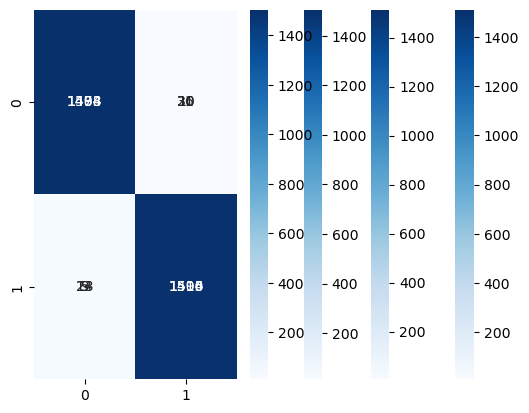

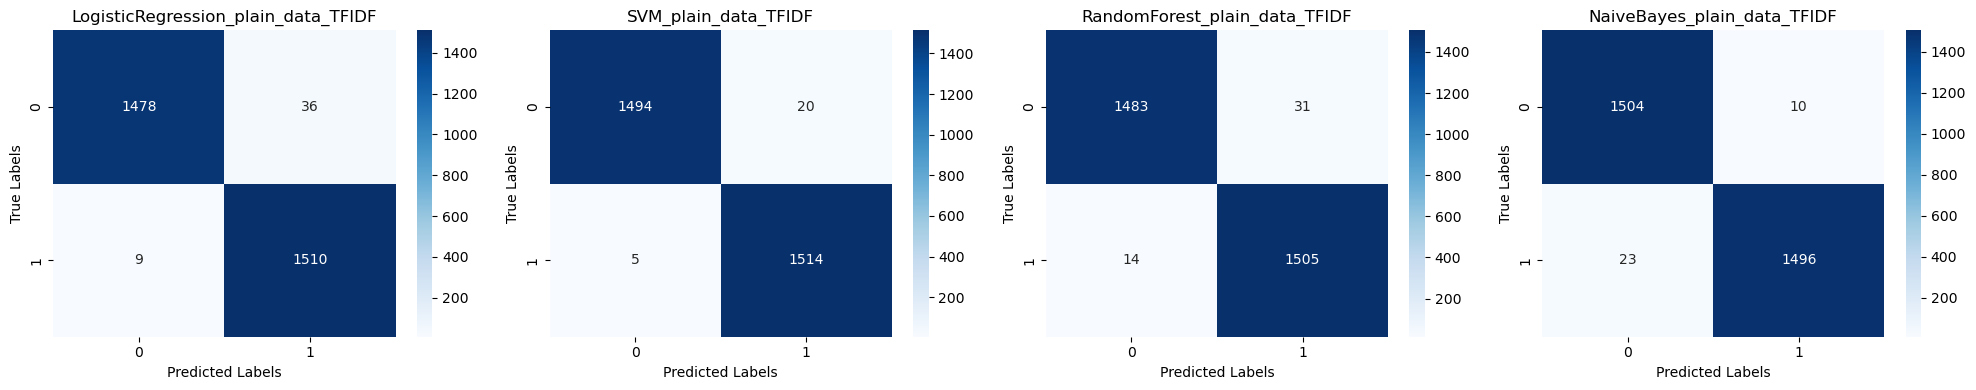

                                 Model  Accuracy  Precision    Recall  \
0  LogisticRegression_plain_data_TFIDF  0.985163   0.976714  0.994075   
1                 SVM_plain_data_TFIDF  0.991757   0.986962  0.996708   
2        RandomForest_plain_data_TFIDF  0.985163   0.979818  0.990783   
3          NaiveBayes_plain_data_TFIDF  0.989120   0.993360  0.984858   

   F1_Score  F05_Score  
0  0.985318   0.980138  
1  0.991811   0.988896  
2  0.985270   0.981991  
3  0.989091   0.991648  
Data: preprocess
Vectorlization: Boolean_Vectorlization
init model LogisticRegression_preprocess_data_Boolean_Vectorlization
init model SVM_preprocess_data_Boolean_Vectorlization
init model RandomForest_preprocess_data_Boolean_Vectorlization
init model NaiveBayes_preprocess_data_Boolean_Vectorlization


Training LogisticRegression_preprocess_data_Boolean_Vectorlization:   0%|          | 0/100 [00:00<?, ?it/s]

Model LogisticRegression_preprocess_data_Boolean_Vectorlization
evaluate report: 
               precision    recall  f1-score   support

         ham       0.99      0.98      0.99      1514
        spam       0.98      0.99      0.99      1519

    accuracy                           0.99      3033
   macro avg       0.99      0.99      0.99      3033
weighted avg       0.99      0.99      0.99      3033

Accuracy: 0.9891196834817013
Precision: 0.9837239583333334
Recall: 0.9947333772218565
F1_Score: 0.9891980360065467
F05_Score: 0.9859063030144852
Model LogisticRegression_preprocess_data_Boolean_Vectorlization saved to .//LogisticRegression_preprocess_data_Boolean_Vectorlization.pkl


Training SVM_preprocess_data_Boolean_Vectorlization:   0%|          | 0/100 [00:00<?, ?it/s]

Model SVM_preprocess_data_Boolean_Vectorlization
evaluate report: 
               precision    recall  f1-score   support

         ham       0.99      0.96      0.98      1514
        spam       0.96      0.99      0.98      1519

    accuracy                           0.98      3033
   macro avg       0.98      0.98      0.98      3033
weighted avg       0.98      0.98      0.98      3033

Accuracy: 0.977909660402242
Precision: 0.9630102040816326
Recall: 0.9940750493745886
F1_Score: 0.9782960803368966
F05_Score: 0.9690668720318316
Model SVM_preprocess_data_Boolean_Vectorlization saved to .//SVM_preprocess_data_Boolean_Vectorlization.pkl


Training RandomForest_preprocess_data_Boolean_Vectorlization:   0%|          | 0/100 [00:00<?, ?it/s]

Model RandomForest_preprocess_data_Boolean_Vectorlization
evaluate report: 
               precision    recall  f1-score   support

         ham       0.99      0.98      0.98      1514
        spam       0.98      0.99      0.98      1519

    accuracy                           0.98      3033
   macro avg       0.98      0.98      0.98      3033
weighted avg       0.98      0.98      0.98      3033

Accuracy: 0.9835146719419716
Precision: 0.977878985035784
Recall: 0.989466754443713
F1_Score: 0.9836387434554974
F05_Score: 0.9801747750097822
Model RandomForest_preprocess_data_Boolean_Vectorlization saved to .//RandomForest_preprocess_data_Boolean_Vectorlization.pkl


Training NaiveBayes_preprocess_data_Boolean_Vectorlization:   0%|          | 0/100 [00:00<?, ?it/s]

Model NaiveBayes_preprocess_data_Boolean_Vectorlization
evaluate report: 
               precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1514
        spam       0.99      0.99      0.99      1519

    accuracy                           0.99      3033
   macro avg       0.99      0.99      0.99      3033
weighted avg       0.99      0.99      0.99      3033

Accuracy: 0.9907682162875041
Precision: 0.992729676140119
Recall: 0.9888084265964451
F1_Score: 0.9907651715039578
F05_Score: 0.9919429401664245
Model NaiveBayes_preprocess_data_Boolean_Vectorlization saved to .//NaiveBayes_preprocess_data_Boolean_Vectorlization.pkl
                                  Confusion Matrix Comparison                                   


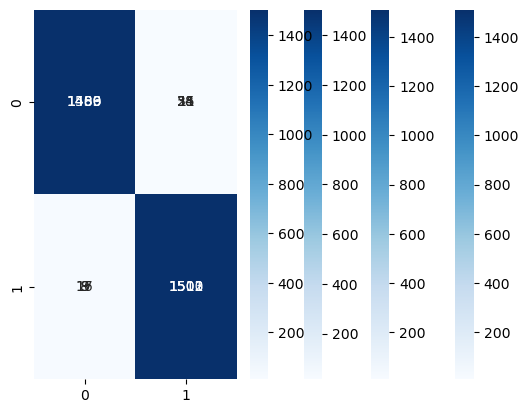

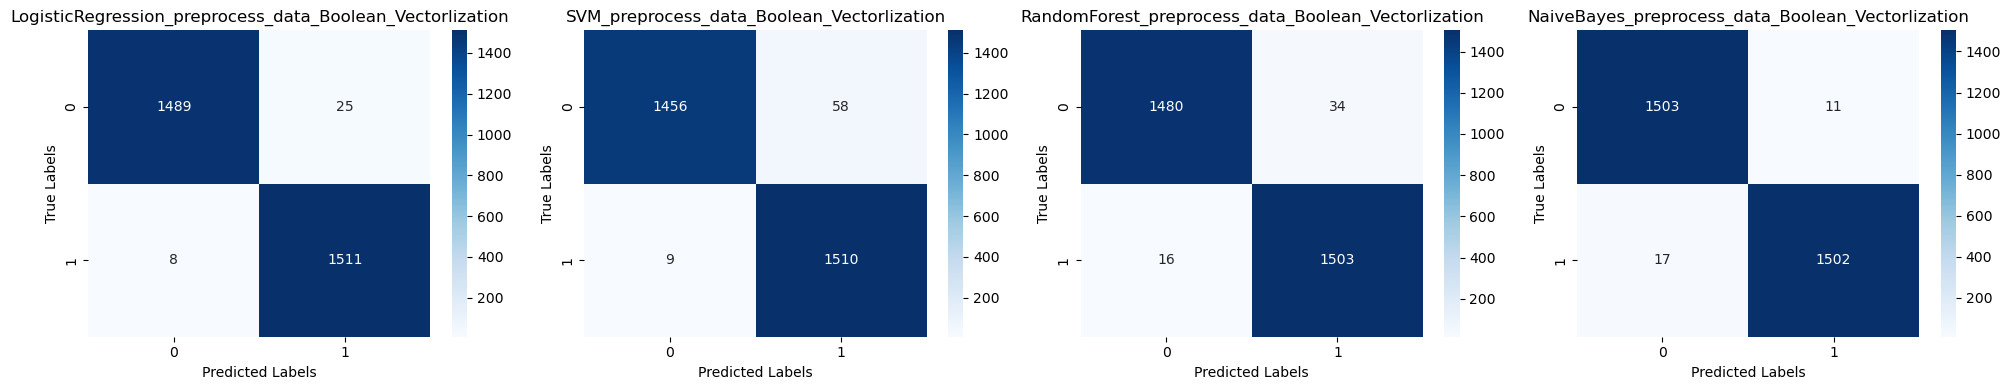

                                               Model  Accuracy  Precision  \
0  LogisticRegression_preprocess_data_Boolean_Vec...  0.989120   0.983724   
1         SVM_preprocess_data_Boolean_Vectorlization  0.977910   0.963010   
2  RandomForest_preprocess_data_Boolean_Vectorliz...  0.983515   0.977879   
3  NaiveBayes_preprocess_data_Boolean_Vectorlization  0.990768   0.992730   

     Recall  F1_Score  F05_Score  
0  0.994733  0.989198   0.985906  
1  0.994075  0.978296   0.969067  
2  0.989467  0.983639   0.980175  
3  0.988808  0.990765   0.991943  
Vectorlization: BoW
init model LogisticRegression_preprocess_data_BoW
init model SVM_preprocess_data_BoW
init model RandomForest_preprocess_data_BoW
init model NaiveBayes_preprocess_data_BoW


Training LogisticRegression_preprocess_data_BoW:   0%|          | 0/100 [00:00<?, ?it/s]

Model LogisticRegression_preprocess_data_BoW
evaluate report: 
               precision    recall  f1-score   support

         ham       0.99      0.98      0.99      1514
        spam       0.98      0.99      0.99      1519

    accuracy                           0.99      3033
   macro avg       0.99      0.99      0.99      3033
weighted avg       0.99      0.99      0.99      3033

Accuracy: 0.9887899769205407
Precision: 0.9843444227005871
Recall: 0.9934167215273206
F1_Score: 0.9888597640891219
F05_Score: 0.9861456018821069
Model LogisticRegression_preprocess_data_BoW saved to .//LogisticRegression_preprocess_data_BoW.pkl


Training SVM_preprocess_data_BoW:   0%|          | 0/100 [00:00<?, ?it/s]

Model SVM_preprocess_data_BoW
evaluate report: 
               precision    recall  f1-score   support

         ham       0.99      0.95      0.97      1514
        spam       0.95      0.99      0.97      1519

    accuracy                           0.97      3033
   macro avg       0.97      0.97      0.97      3033
weighted avg       0.97      0.97      0.97      3033

Accuracy: 0.9693372898120672
Precision: 0.9506953223767383
Recall: 0.990125082290981
F1_Score: 0.9700096742986134
F05_Score: 0.9583280234484516
Model SVM_preprocess_data_BoW saved to .//SVM_preprocess_data_BoW.pkl


Training RandomForest_preprocess_data_BoW:   0%|          | 0/100 [00:00<?, ?it/s]

Model RandomForest_preprocess_data_BoW
evaluate report: 
               precision    recall  f1-score   support

         ham       0.99      0.98      0.99      1514
        spam       0.98      0.99      0.99      1519

    accuracy                           0.99      3033
   macro avg       0.99      0.99      0.99      3033
weighted avg       0.99      0.99      0.99      3033

Accuracy: 0.9868117375535773
Precision: 0.9836494440810988
Recall: 0.990125082290981
F1_Score: 0.9868766404199475
F05_Score: 0.9849377865094957
Model RandomForest_preprocess_data_BoW saved to .//RandomForest_preprocess_data_BoW.pkl


Training NaiveBayes_preprocess_data_BoW:   0%|          | 0/100 [00:00<?, ?it/s]

Model NaiveBayes_preprocess_data_BoW
evaluate report: 
               precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1514
        spam       0.99      0.99      0.99      1519

    accuracy                           0.99      3033
   macro avg       0.99      0.99      0.99      3033
weighted avg       0.99      0.99      0.99      3033

Accuracy: 0.9904385097263435
Precision: 0.9927248677248677
Recall: 0.9881500987491771
F1_Score: 0.9904322005938634
F05_Score: 0.9918065283467689
Model NaiveBayes_preprocess_data_BoW saved to .//NaiveBayes_preprocess_data_BoW.pkl
                                  Confusion Matrix Comparison                                   


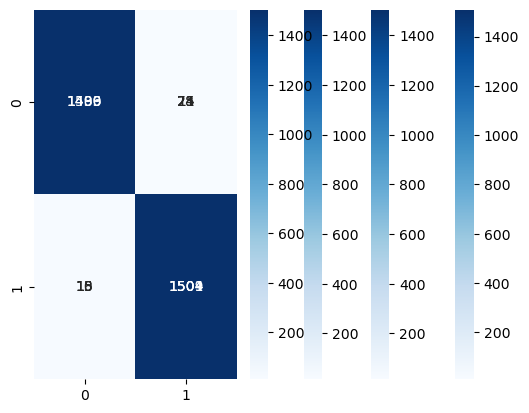

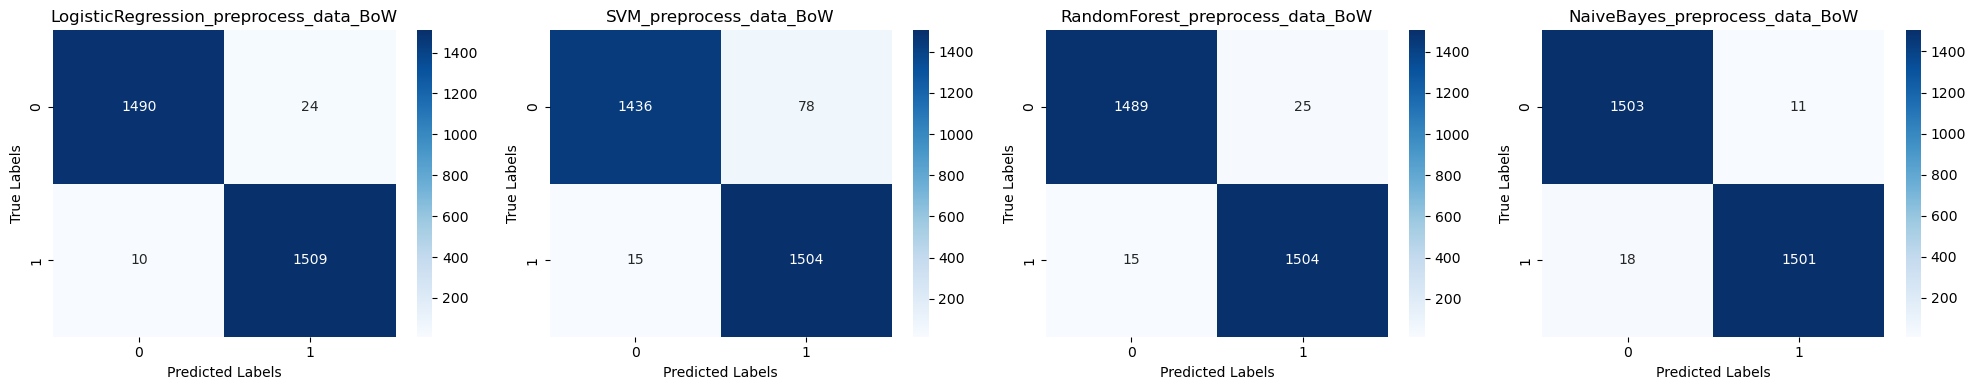

                                    Model  Accuracy  Precision    Recall  \
0  LogisticRegression_preprocess_data_BoW  0.988790   0.984344  0.993417   
1                 SVM_preprocess_data_BoW  0.969337   0.950695  0.990125   
2        RandomForest_preprocess_data_BoW  0.986812   0.983649  0.990125   
3          NaiveBayes_preprocess_data_BoW  0.990439   0.992725  0.988150   

   F1_Score  F05_Score  
0  0.988860   0.986146  
1  0.970010   0.958328  
2  0.986877   0.984938  
3  0.990432   0.991807  
Vectorlization: TFIDF
init model LogisticRegression_preprocess_data_TFIDF
init model SVM_preprocess_data_TFIDF
init model RandomForest_preprocess_data_TFIDF
init model NaiveBayes_preprocess_data_TFIDF


Training LogisticRegression_preprocess_data_TFIDF:   0%|          | 0/100 [00:00<?, ?it/s]

Model LogisticRegression_preprocess_data_TFIDF
evaluate report: 
               precision    recall  f1-score   support

         ham       0.99      0.98      0.99      1514
        spam       0.98      0.99      0.99      1519

    accuracy                           0.99      3033
   macro avg       0.99      0.99      0.99      3033
weighted avg       0.99      0.99      0.99      3033

Accuracy: 0.9858226178700956
Precision: 0.977979274611399
Recall: 0.9940750493745886
F1_Score: 0.9859614756774404
F05_Score: 0.9811565951916829
Model LogisticRegression_preprocess_data_TFIDF saved to .//LogisticRegression_preprocess_data_TFIDF.pkl


Training SVM_preprocess_data_TFIDF:   0%|          | 0/100 [00:00<?, ?it/s]

Model SVM_preprocess_data_TFIDF
evaluate report: 
               precision    recall  f1-score   support

         ham       1.00      0.98      0.99      1514
        spam       0.99      1.00      0.99      1519

    accuracy                           0.99      3033
   macro avg       0.99      0.99      0.99      3033
weighted avg       0.99      0.99      0.99      3033

Accuracy: 0.990108803165183
Precision: 0.9850162866449511
Recall: 0.9953917050691244
F1_Score: 0.9901768172888016
F05_Score: 0.9870740305522914
Model SVM_preprocess_data_TFIDF saved to .//SVM_preprocess_data_TFIDF.pkl


Training RandomForest_preprocess_data_TFIDF:   0%|          | 0/100 [00:00<?, ?it/s]

Model RandomForest_preprocess_data_TFIDF
evaluate report: 
               precision    recall  f1-score   support

         ham       0.99      0.98      0.99      1514
        spam       0.98      0.99      0.99      1519

    accuracy                           0.99      3033
   macro avg       0.99      0.99      0.99      3033
weighted avg       0.99      0.99      0.99      3033

Accuracy: 0.985492911308935
Precision: 0.9798308392973325
Recall: 0.9914417379855168
F1_Score: 0.9856020942408377
F05_Score: 0.9821312116864485
Model RandomForest_preprocess_data_TFIDF saved to .//RandomForest_preprocess_data_TFIDF.pkl


Training NaiveBayes_preprocess_data_TFIDF:   0%|          | 0/100 [00:00<?, ?it/s]

Model NaiveBayes_preprocess_data_TFIDF
evaluate report: 
               precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1514
        spam       0.99      0.99      0.99      1519

    accuracy                           0.99      3033
   macro avg       0.99      0.99      0.99      3033
weighted avg       0.99      0.99      0.99      3033

Accuracy: 0.9904385097263435
Precision: 0.9927248677248677
Recall: 0.9881500987491771
F1_Score: 0.9904322005938634
F05_Score: 0.9918065283467689
Model NaiveBayes_preprocess_data_TFIDF saved to .//NaiveBayes_preprocess_data_TFIDF.pkl
                                  Confusion Matrix Comparison                                   


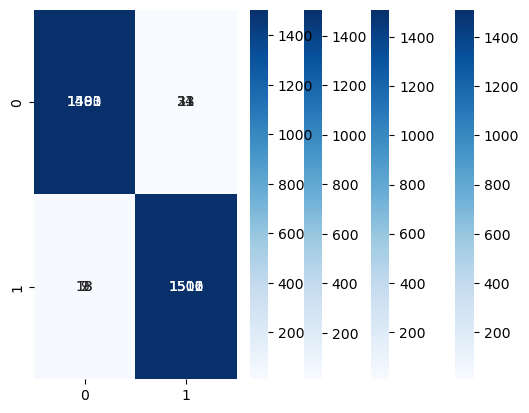

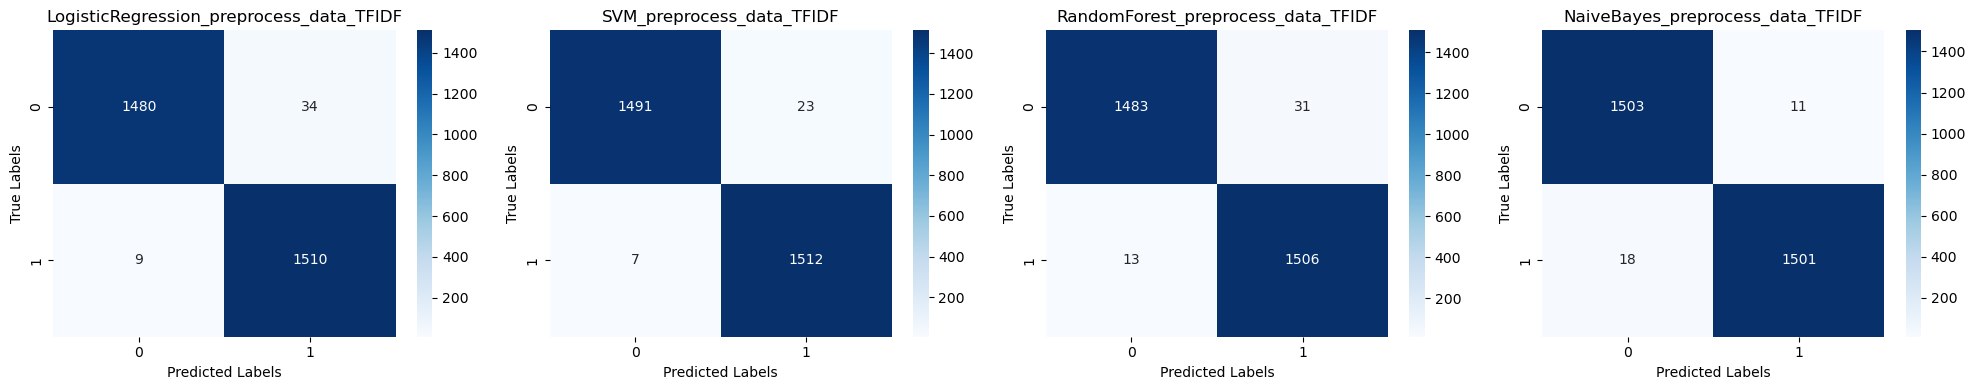

                                      Model  Accuracy  Precision    Recall  \
0  LogisticRegression_preprocess_data_TFIDF  0.985823   0.977979  0.994075   
1                 SVM_preprocess_data_TFIDF  0.990109   0.985016  0.995392   
2        RandomForest_preprocess_data_TFIDF  0.985493   0.979831  0.991442   
3          NaiveBayes_preprocess_data_TFIDF  0.990439   0.992725  0.988150   

   F1_Score  F05_Score  
0  0.985961   0.981157  
1  0.990177   0.987074  
2  0.985602   0.982131  
3  0.990432   0.991807  


In [44]:
# All Model with plain data
model_config_list = [LogisticRegressionConfig(), SVMConfig(), RandomForestConfig(), NaiveBayesConfig()]
vectorlizationList = [BooleanVectorlization(), BoWVectorlization(), TFIDFVectorlization()]

dataDictionary = {
    'plain': plain_model_data,
    'preprocess': preprocess_model_data
}

diction = {}

labels = []
for key in dataDictionary:
  print(f"Data: {key}")
  labels.append(key)
  modelData = dataDictionary[key]
  diction[key] = {}

  for vectorlization in vectorlizationList:
      vectorlizationName = vectorlization.getName()
      print(f"Vectorlization: {vectorlizationName}")
      labels.append(vectorlizationName)
      diction[key][vectorlizationName] = {}

      model_list = []
      for model_config in model_config_list:
        model_list.append(Model(model_config, modelData, vectorlization, evaluationListManger))

      models_report = Evaluation_Models_Results(model_list, evaluationListManger, f"{key}_{vectorlizationName}")
      result = models_report.generate_report()
      diction[key][vectorlizationName] = result


In [109]:
preprocess_model_data.X_train


Message ID
0                                christma tree farm pictur
1        vastar resourc inc gari product high island la...
2        calpin daili ga nomin calpin daili ga nomin 1 doc
3        issu fyi see note alreadi done stella forward ...
5        mcmullen ga 11 99 jacki sinc inlet 3 river pla...
                               ...                        
33709    cure prematur ejacul hello ejacul within minut...
33711    error hello welcom gigapharm onlinn shop presc...
33712    prescript medicin special precis put buck back...
33713    next gener onlin pharmaci readi rock let man r...
33714    bloow 5 10 time time learn last 5 10 time long...
Name: transform_text, Length: 25023, dtype: object

### Tìm hiểu sâu về mô hình Multinomial Bayes

init model NaiveBayes_preprocess_data_BoW
Model NaiveBayes_preprocess_data_BoW load from .//NaiveBayes_preprocess_data_BoW.pkl
Model NaiveBayes_preprocess_data_BoW
evaluate report: 
               precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1514
        spam       0.99      0.99      0.99      1519

    accuracy                           0.99      3033
   macro avg       0.99      0.99      0.99      3033
weighted avg       0.99      0.99      0.99      3033

Accuracy: 0.9904385097263435
Precision: 0.9927248677248677
Recall: 0.9881500987491771
F1_Score: 0.9904322005938634
F05_Score: 0.9918065283467689


{'Accuracy': 0.9904385097263435,
 'Precision': 0.9927248677248677,
 'Recall': 0.9881500987491771,
 'F1_Score': 0.9904322005938634,
 'F05_Score': 0.9918065283467689}

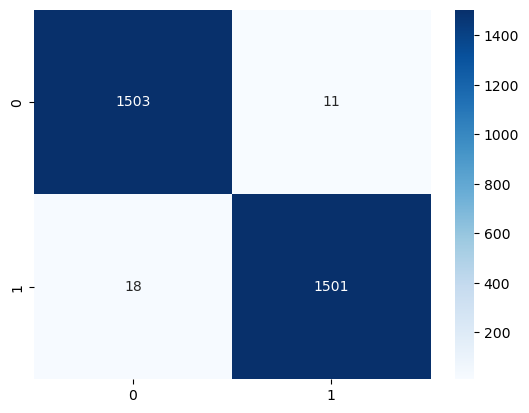

In [57]:
naiveBayesModel = Model(NaiveBayesConfig(), preprocess_model_data, BoWVectorlization(), evaluationListManger)

if not naiveBayesModel.loadModel():
  naiveBayesModel.train()
  naiveBayesModel.saveModel()

# Evaluate Model with Valid Data
naiveBayesModel.evaluate_valid(is_report=True)

In [60]:
## Collect data with wrong label prediction
wrong_label = valid[valid[resultCol] != naiveBayesModel.y_predict()]
wrong_label[resultCol] = encoder.inverse_transform(wrong_label[resultCol])
print(f"Number of wrong label: {len(wrong_label)}")
wrong_label

Number of wrong label: 29


/var/folders/70/m4pwz78n73x_xqbtcmfmxt5c0000gn/T/ipykernel_66827/321573998.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrong_label[resultCol] = encoder.inverse_transform(wrong_label[resultCol])


,Subject,Message,Result,full_message,transform_text
Message ID,,,,,
300,valentines day help,red - neck valentine ' s love poem\ncollards i...,ham,valentines day help red - neck valentine ' s l...,valentin day help red neck valentin love poem ...
609,registration confirmation - my yahoo !,account information\nhelp\ndo not reply to thi...,ham,registration confirmation - my yahoo ! account...,registr confirm yahoo account inform help repl...
3098,freedom ? ? ?,bammelyoungfamilies\n- - - - - - - - - - - - -...,ham,freedom ? ? ? bammelyoungfamilies\n- - - - - -...,freedom bammelyoungfamili listbot sponsor star...
3450,fw : i am # 470,"i have felt a renewed heart for god , a fresh ...",ham,fw : i am # 470 i have felt a renewed heart fo...,fw 470 felt renew heart god fresh spirit word ...
3832,re : no more injections,,spam,re : no more injections,inject
4141,,,spam,,
13264,how bout this one .,,ham,how bout this one .,bout one
14328,fw :,very symbolic of our current struggle,ham,fw : very symbolic of our current struggle,fw symbol current struggl
15295,#ERROR!,#ERROR!,spam,#ERROR! #ERROR!,error error
